In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip gdrive/MyDrive/EngChars.zip > /dev/null

# English Character classifier
###### Charlie Rosander, 2023-08

In this project we will create a CNN to recognise and classify english, handwritten characters (0-9, A-Z).

The dataset we are using is the "English handwritten characters" from kaggle:
https://www.kaggle.com/datasets/dhruvildave/english-handwritten-characters-dataset

"This dataset contains 3,410 images of handwritten characters in English. This is a classification dataset that can be used for Computer Vision tasks. It contains 62 classes with 55 images of each class. The 62 classes are 0-9, A-Z and a-z."

# The dataset
Looking over the dataset i can see right away that all of the pictures are written in a program like paint and not by hand with pen and paper, which is a bit of a shame as this will most likely overfit the model and make the model perform worse on real handwritten characters.

We will see how it performs and later on I will do a "real-world" test with my own handwriting to see if I can test the limits of the model.

# Procedure

We will start with the imports and then load the data into a dataframe. We will then do some preprocessing and then create the model, followed by the testing and analysis of the model. I will make the model savable so that we can continue to train it later on if we want to.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1, l2, l1_l2
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
import pandas as pd


#### Loading the data and labeling it
Here we create some funcs to handle the images. We take the names and labels from a CSV file included with the dataset, then load the images, rescale and normalize them. I am also utilizing "ThreadPoolExecutor" to use more threads for the data loading, reducing the speed it takes to load the data by up to 10x.

In [2]:
#################### VARS ######################
directory_path = "./EngChars/Img/"
csv_path = "./EngChars/english.csv"
################################################


def label_to_int(label):
    if label.isdigit():
        return int(label)
    elif label.isupper():
        return 10 + ord(label) - ord('A')
    elif label.islower():
        return 36 + ord(label) - ord('a')

def load_image_from_row(row, directory_path):
    img_path = os.path.join(directory_path, row.image[4:])
    label = row.label

    img = cv2.imread(img_path)
    img = cv2.resize(img, (84, 84))
    img = img / 255.0  # normalize

    label_index = label_to_int(label)

    return img, label_index

def load_images_from_csv(csv_path, directory_path):
    images = []
    labels = []

    df = pd.read_csv(csv_path)

    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda row: load_image_from_row(row, directory_path), df.itertuples(index=False)))

    for img, label_index in results:
        images.append(img)
        labels.append(label_index)

    images = np.array(images)
    labels = to_categorical(np.array(labels))

    return images, labels

# Load the images and labels
images, labels = load_images_from_csv(csv_path, directory_path)

Split the data into train/validation.

In [3]:
# Split data into training and testing
x_train, x_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42)



#### Image Augmentation

Here we apply some image augmentation to further counter overfitting aswell as artificially increase the size of our dataset, which hopefully makes it more robust and better at generalization.

In [4]:
train_datagen = ImageDataGenerator(
    rotation_range=30,      # rotate the image 30 degrees
    width_shift_range=0.1,  # Shift the pic width by a max of 10%
    height_shift_range=0.1, # Shift the pic height by a max of 10%
    rescale=1./255,         # Rescale the image by normalizing it.
    shear_range=0.2,        # Shear means cutting away part of the image (max 20%)
    zoom_range=0.2,         # Zoom in by 20% max
    horizontal_flip=True,   # Allow horizontal flipping
    fill_mode='nearest'     # Fill in missing pixels with the nearest filled value
)

# Fit the generator to your train data
train_datagen.fit(x_train)

In [5]:
# Kollar så att det ser ut som vi förväntar oss, vilket det gör
print(x_train.shape)
print(x_test.shape)

(2728, 84, 84, 3)
(682, 84, 84, 3)


#### Create the model
Here we create our model, I have chosen to use 4 hidden layers with 2 convolutional layers and 2 dense layers. This is where the tweaking and fine-tuning takes place aswell. Finding the right values for the parameters is the hard part of this project.

In [13]:
##################################
regularization_rate = 0.007
epoch_num = 60
batch_size = 16
##################################

# Create model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(84, 84, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # Dropout added

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # Dropout added

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # Dropout added

model.add(Flatten())
model.add(Dense(128, activation='relu',
          kernel_regularizer=l2(regularization_rate)))
model.add(Dropout(0.5))  # Dropout added

model.add(Dense(62, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Training the model
Here we do the actual training, as well as saving the model to a directory. This is done to be able to continue training a already created model.

In [14]:
# Train model
history = model.fit(x_train, y_train, epochs=epoch_num,
                    batch_size=batch_size, validation_data=(x_test, y_test))

# Save model, create dir if not exists
if not os.path.exists('models'):
    os.makedirs('models')

model.save('models/model.h5')

Epoch 1/60
171/171 [==============================] - 15s 83ms/step - loss: 4.6062 - accuracy: 0.0147 - val_loss: 4.1956 - val_accuracy: 0.0103
Epoch 2/60
171/171 [==============================] - 14s 82ms/step - loss: 4.1511 - accuracy: 0.0139 - val_loss: 4.1351 - val_accuracy: 0.0073
Epoch 3/60
171/171 [==============================] - 14s 81ms/step - loss: 4.1292 - accuracy: 0.0180 - val_loss: 4.1322 - val_accuracy: 0.0073
Epoch 4/60
171/171 [==============================] - 14s 81ms/step - loss: 4.1276 - accuracy: 0.0176 - val_loss: 4.1329 - val_accuracy: 0.0073
Epoch 5/60
171/171 [==============================] - 14s 82ms/step - loss: 4.1256 - accuracy: 0.0187 - val_loss: 4.1133 - val_accuracy: 0.0088
Epoch 6/60
171/171 [==============================] - 14s 82ms/step - loss: 4.0752 - accuracy: 0.0260 - val_loss: 4.0054 - val_accuracy: 0.0352
Epoch 7/60
171/171 [==============================] - 14s 82ms/step - loss: 4.0109 - accuracy: 0.0290 - val_loss: 3.8967 - val_accuracy:

#### Plotting and visualising the results.
To me, one of the most important parts of a project like this is visualisation. That's the best way to see how your model performs, and it's also where the "Aha!" moments happen.

So here we create a couple of simple plots just to get a good look at the curve of the graph, the convergence and general behaviour of the model.

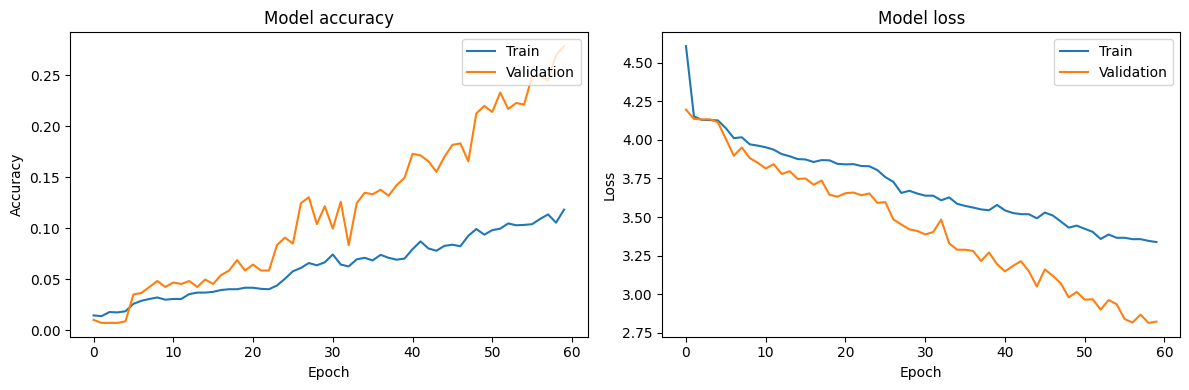

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [15]:
if not os.path.exists('./Plots/'):
    os.makedirs('./Plots/')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("./Plots/acc_vals.jpg")

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("./Plots/loss_vals.jpg")

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

#### Double checking results
Here we create another plot, taking 9 random validations with their respective label and prediction. This is where AI really comes to life for me personally, being able to see behind the curtain and realise that the code you've written are making genuine, accurate predictions.

Again with the visualisation; this is where you hopefully get a better understanding as to why the model predicted wrong. In most cases from what I have seen, even many humans could've guessed wrong.

22/22 [==============================] - 1s 33ms/step


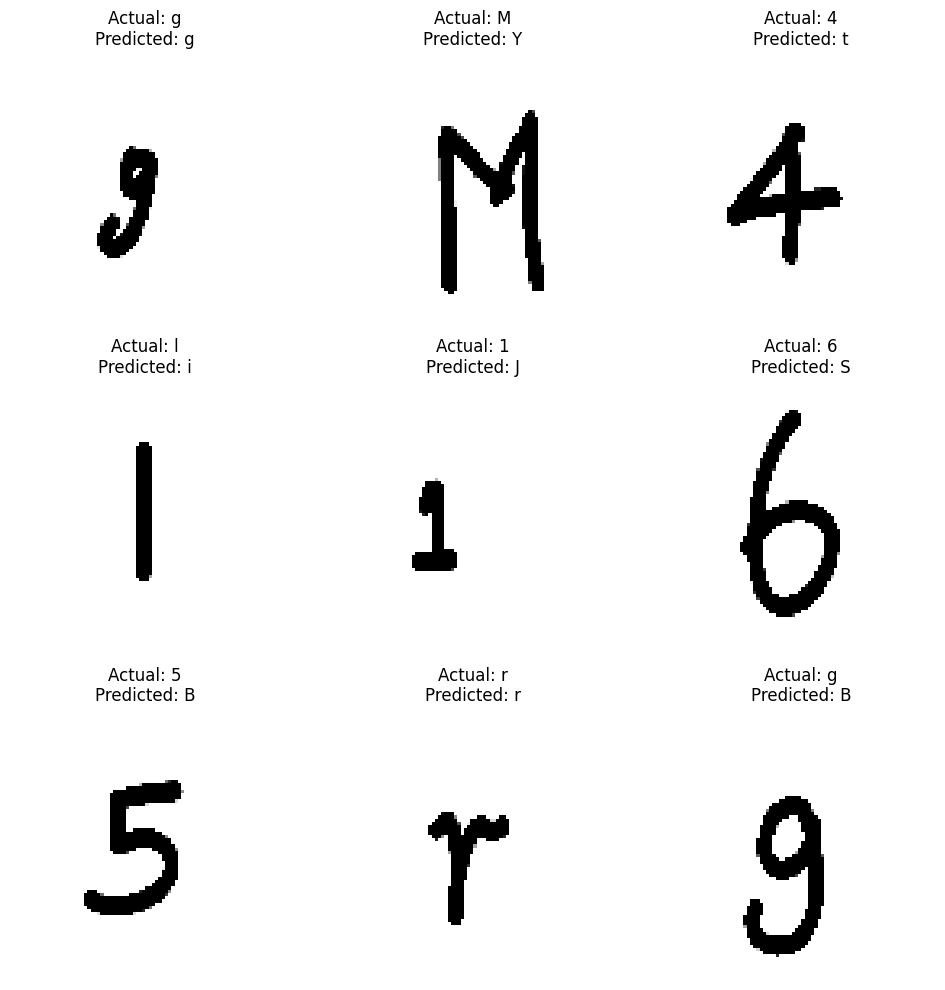

In [16]:
def int_to_label(i):
    if i < 10:
        return str(i)
    elif i < 36:
        return chr(i - 10 + ord('A'))
    else:
        return chr(i - 36 + ord('a'))

# Get predictions
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

# Convert categorical array to original label
actual_labels = np.argmax(y_test, axis=1)

# Choose random indices to visualize
random_indices = np.random.choice(x_test.shape[0], size=9, replace=False)

plt.figure(figsize=(10, 10))

for i, index in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[index])
    plt.title(f"Actual: {int_to_label(actual_labels[index])}\nPredicted: {int_to_label(predicted_labels[index])}")
    plt.axis('off')

plt.tight_layout()
plt.show()